In [8]:
import sys
sys.path.append('../')
import helper_functions.ppc as ppc
import pyro
from pyro import plate
import pyro.distributions as dist
import pyro.contrib.autoguide as autoguide
from pyro.infer import MCMC, NUTS, SVI, Trace_ELBO, Predictive
import pyro.optim as optim
import numpy as np
import scipy.signal as signal
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import plotly.express as px
import plotly.graph_objects as go
import datetime
import folium
import seaborn as sns
from folium.plugins import FastMarkerCluster, HeatMap
from plotly.offline import init_notebook_mode, iplot
from torch.distributions.constraints import positive

init_notebook_mode(connected=True)
FIRST_DAY = datetime.datetime(2014,1,1)


First we will fit a simple linear model to our data to see how it performs. This will consist of no structured componenets, nor any additional covariates or predictors. It will be used as the baseline with respect to which we can evaluate all of our additional models. To do so first we will take a quick look at our data. 

In [9]:
def transform_dataframe(df): 
    """
    Transforms dataframe with ``datetime`` and ``node`` cols 
    Into [day,node] nd.array where arr[i][j] indicates
    accidents in location i at j day 
    Returns accident array
    """
    #Categories for classifying the codes
    df = df.copy()
    
    categorical = pd.Categorical(df['node'])
    codes = categorical.codes

    num_days = (df['datetime'].iloc[-1] - FIRST_DAY).days + 1
    num_nodes = len(categorical.categories)

    data_arr = np.zeros((num_nodes, num_days))
    for elem, i in zip(df.itertuples(),range(len(df))): 
        data_arr[codes[i]][(elem.datetime - FIRST_DAY).days] += 1
    
    category_mapping = {}
    for node, idx in zip(categorical, categorical.codes):
        category_mapping[node] = idx 
    
    return num_days, category_mapping, data_arr


In [10]:
accident_filename = '../data/manhattan_accidents_node_data.csv'
node_filename = '../data/nodes_roads.csv'


data = pd.read_csv(accident_filename)
node_data = pd.read_csv(node_filename)

#Only consider accident with node that have corresponding AADT
data = data[data['node'].isin(list(node_data['nodes'].unique()))]

#Only consider accidents after 2014
data['datetime'] = pd.to_datetime(data['datetime'])
data = data[data['datetime'] >= FIRST_DAY]

#This is done to get rid of pesky column. 
data

,Unnamed: 0,datetime,longitude,latitude,node
65727,257388,2014-01-01 00:01:00,-73.981512,40.767889,4347550071
65728,257389,2014-01-01 00:01:00,-73.978608,40.750844,561042199
65729,257390,2014-01-01 00:01:00,-73.996771,40.725432,1919595915
65731,257412,2014-01-01 02:00:00,-73.965784,40.758633,42442960
65732,257414,2014-01-01 02:02:00,-73.944677,40.791570,42450057
...,...,...,...,...,...
335808,1520426,2020-10-30 20:15:00,-73.988520,40.745200,42428223
335809,1520434,2020-10-30 20:44:00,-73.949486,40.772705,42428024
335810,1520445,2020-10-30 21:46:00,-73.975840,40.748863,42445661
335811,1520450,2020-10-30 22:15:00,-73.920616,40.866760,42431242


First we can divide the data between a training and test set. To do this we can simply take the time up to year 2016 and then consider everything else validation.  Moreover we will re-organize our data so that we can work with it a comfortable way later on. 

In [11]:
num_days, categorical_mapping, data_mat = transform_dataframe(data)

num_years_test = 2
num_years_train = 3

index_train = 365 * num_years_train
index_valid = index_train + 365 * num_years_test

train_mat = data_mat[:, :index_train]
test_mat = data_mat[:, index_train: index_valid]
data_mat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

To understand the data that we have we can plot several visualizations. First we will plot the points in the map so that we can see what type of data we are dealing with. 

In [ ]:
m = folium.Map(location=[40.7, -74.05], zoom_start=10)

subset = data[['latitude','longitude']][:].values.tolist()
m.add_child(FastMarkerCluster(subset))


m

In addition to being able to visualize the points independently it is also helpful to visualize the points in a heat map to understand if there are any spatial correlations that we should be mindful of. As the map shows, there are definitely some areas that seem to be more likely to have accidents than others. 


In [ ]:
m = folium.Map(location=[40.7, -74.05], zoom_start=10)

subset = data[['latitude','longitude']][:].values.tolist()
m.add_children(HeatMap(subset, radius = 7.5))
m


One important thing to understand and which will be key later on is whether there exists some general trends on accidents through time. Of course, it is possible that for some sites some of these trends are present while for some others these trends don't exist. However, for the moment we will only consider whether for manhattan as whole these trends exist. 

In [ ]:
time_accidents = np.sum(data_mat, axis = 0)
smooth_accidents = signal.savgol_filter(time_accidents,61, 3)
time = list(range(len(time_accidents)))
fig = go.Figure()
fig.add_trace(go.Scatter(x=time,y=time_accidents, mode='lines',name='Raw accidents'))
fig.add_trace(go.Scatter(x=time,y=smooth_accidents,mode='lines',name='Smooth accidents'))
fig.show()


Now, there are two 

In [ ]:
mean_accidents = np.sum(train_mat, axis = 1)/len(train_mat)
sns.displot(pd.DataFrame({'mean accidents':mean_accidents}), x='mean accidents', kind = 'kde')



In [ ]:
mean_accidents = np.sum(train_mat, axis = 1)/len(train_mat)
sns.displot(pd.DataFrame({'log mean accidents':np.log(mean_accidents + 0.000000000001/len(mean_accidents))}), x='log mean accidents', kind = 'kde', ax=1)

Now we will specify our model. Our first model is that both the risk and exposure at each individual site will be constant through time. This is a very crude approximation but it will serve as a simple baseline that we can use for our evaluation. Mathematically, we can state is as follows. Let $j \in [n]$ where $n$ denotes the number of days. Let $i \in [m]$ where $m$ denotes the number of sites. Let $Y_{ij}$ the number of accidents at site $i$ during during day $j$. Then we assume that 
\begin{align*}
\beta &\sim \mathcal{N}(0,I_m)\\
Y_{ij} &\sim \text{Poisson}(\exp(\beta_i))
\end{align*}
Having specified this, we can simply write down our model and then do inference. Because the betas are independent here, then it would make sense to specify a guide where all of the parameters are normal. This can be done quite easily with an autoguide. 

In [16]:
num_sites = train_mat.shape[0]
num_days = train_mat.shape[1]

def base_model(num_sites, num_days, data=None):
    with plate('sites', size=num_sites, dim=-2):
        epsilon = pyro.sample('epsilon', dist.Normal(-5, 3))
        with plate('days', size=num_days, dim=-1):
            accidents = pyro.sample('accidents', dist.Poisson(torch.exp(epsilon)), obs=data)
            
    return accidents


In [ ]:
guide = autoguide.AutoDiagonalNormal(base_model)
optimizer = optim.Adam({'lr': .05})
num_iters = 500

svi = SVI(base_model, guide, optimizer,loss=Trace_ELBO())

pyro.clear_param_store()
losses = []
train_mat_tens = torch.tensor(train_mat)
for i in range(num_iters): 
    elbo = svi.step(num_sites, num_days, train_mat_tens)
    losses.append(elbo)
    if i % 50 == 0: 
        print("In step {} the Elbo is {}".format(i,elbo))

In [ ]:
elbo_df = pd.DataFrame({'Iteration': list(range(len(losses))), 'Loss': np.log(losses[:])})
fig = px.line(elbo_df, x='Iteration', y='Loss', title='Elbo')
fig.show()

In [ ]:
predict = Predict(base_model,guide, 800)
samples = predict(num_sites, num_days)

In [ ]:
subset = torch.distributions.Categorical(torch.ones(4,num_sites)/num_sites).sample()
print(subset)
ppc.plot_total_distributions(samples['accidents'].detach().numpy(),train_mat,(2,2),subset)

Naturally, the next step is to import predictor data. This would include both intersection-level data such as AADT and day-level data such as weather.

In [ ]:
def transform_nodes_dataframe(categorical_mapping, df): 
    """
    Transforms dataframe with ``node`` and corresponding predictor cols 
    Into [day,node,predictor] nd.array where arr[j][i][k] indicates
    predictor k in location i at j day 
    Returns predictors tensor
    """
    #Categories for classifying the codes
    df = df.copy()
    
    df = df.replace({'nodes': categorical_mapping})

    num_nodes = len(categorical_mapping.keys())
    
    data_arr = np.zeros((num_nodes, num_days, 2))
    for i in range(len(df)): 
        if df['nodes'][i] >= 0 and df['nodes'][i] <= data_arr.shape[0]:
            data_arr[df['nodes'][i], :, 0] = 1
            data_arr[df['nodes'][i], :, 1] = df['Count_mean'][i]
    return data_arr


predictors = transform_nodes_dataframe(categorical_mapping, node_data)


In [ ]:
node_data

The model that we use now is gonna be different. Before, we had all of our risk and exposure at a crash site modeled by one term per site. Here we introduce several modifications and choose the following model instead. As before, let $Y_{ij}$ denote the number of car crashes at site $i$ on day $j$. Now we introduce a variable $theta_{ij}$  which we will call the risk at site $i$ on day $j$ of a crash and a variable $\lambda_{ij}$ which we call the exposure at site $i$ on day $j$. This exporsure, is associated with the number of cars that pass through a given site on a day. Intuitively, the more cars that pass through some site on a day. Our model then is 



In [ ]:
predictors[:,:,1] = np.log(predictors[:,:,1])

In [ ]:
def aadt_model(num_sites, num_days, num_predictors,predictors, data=None):
    betas = pyro.sample('betas', dist.Normal(0 * torch.ones(num_predictors), 2 * torch.ones(num_predictors)))
    thetas = predictors @ betas
    with plate('sites', size=num_sites, dim=-2):
        epsilon = pyro.sample('epsilon', dist.Normal(0, 5)).expand(num_sites, num_days)
        with plate('days', size=num_days, dim=-1):
            thetas = thetas + epsilon
            accidents = pyro.sample('accidents', dist.Poisson(torch.exp(thetas)), obs=data) 

    return accidents

In [ ]:
aadt_model_guide = autoguide.AutoDiagonalNormal(aadt_model)
num_iters = 1000
optimizer = torch.optim.Adam
optim_args = {'lr': 0.05}
optim_params = {
    'optimizer': optimizer,
    'optim_args':optim_args, 
    'step_size': 200,
    'gamma':0.1,
    'verbose':True}
scheduler = optim.StepLR(optim_params)

svi = SVI(aadt_model, aadt_model_guide, scheduler,loss=Trace_ELBO())

pyro.clear_param_store()
losses = []
train_mat_tens = torch.tensor(train_mat)
predictors_tens = torch.tensor(predictors).float()
covariates = predictors_tens
for i in range(num_iters): 
    elbo = svi.step(num_sites, num_days, 2, predictors_tens, train_mat_tens)
    losses.append(elbo)
    if i % 50 == 0: 
        print("In step {} the Elbo is {}".format(i,elbo))

In [ ]:
elbo_df = pd.DataFrame({'Iteration': list(range(len(losses))), 'log-loss': np.log(losses[:])})
fig = px.line(elbo_df, x='Iteration', y='log-loss', title='Elbo')
fig.show()

In [ ]:
# This should go in an independent file 
from collections import defaultdict
from pyro import poutine
from pyro.poutine.util import prune_subsample_sites
import warnings

class Predict(torch.nn.Module):
    def __init__(self, model, guide, num_samples=800):
        super().__init__()
        self.model = model
        self.guide = guide
        self.num_samples = num_samples

    def forward(self, *args, **kwargs):
        total_samples = {}
        for i in range(self.num_samples): 
            if i % 50 == 0: 
                print("done with {}".format(i))
            guide_trace = poutine.trace(self.guide).get_trace(*args, **kwargs)
            model_trace = poutine.trace(poutine.replay(self.model, guide_trace)).get_trace(*args, **kwargs)
            for site in prune_subsample_sites(model_trace).stochastic_nodes:
                if site not in total_samples: 
                    total_samples[site] = []
                total_samples[site].append(model_trace.nodes[site]['value'])
        for key in total_samples.keys():
            total_samples[key] = torch.stack(total_samples[key])

        return total_samples
    

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

In [ ]:
num_predictors = 2
predict = Predict(aadt_model,aadt_model_guide, 400)
samples = predict(num_sites, num_days, num_predictors, predictors_tens)


In [ ]:
sns.displot(samples['betas'][:,0].detach().numpy())

In [ ]:
subset = torch.distributions.Categorical(torch.ones(4,num_sites)/num_sites).sample()
print(subset)
ppc.plot_total_distributions(samples['accidents'].detach().numpy(),train_mat,(2,2),subset)

In [ ]:
ppc.plot_max(samples['accidents'].detach().numpy(), train_mat)

In [ ]:
def add_weather_predictors(predictors, df):
    df = df.copy()
    new_predictors = np.zeros((predictors.shape[0], predictors.shape[1], 6))
    df['datetime'] = pd.to_datetime(df['DATE'])
    for elem in df.itertuples():
        idx = (elem.datetime - FIRST_DAY).days
        
        if idx >= 0 and idx < new_predictors.shape[1]:
            new_predictors[:, idx, 2:] = [elem.AWND, elem.PRCP, elem.SNWD, elem.TAVG]
    new_predictors[:, :, :2] = predictors
    return new_predictors
weather_data = pd.read_csv('../data/weather.csv')
new_predictors = add_weather_predictors(predictors, weather_data)

# Step to normalize the variables to be between -1 and 1
new_predictors = new_predictors/np.max(np.abs(new_predictors[0]), axis = 0)

In [ ]:
weather_data

In [ ]:
aadt_model_guide = autoguide.AutoDiagonalNormal(aadt_model)
num_iters = 1000
optimizer = torch.optim.Adam
optim_args = {'lr': 0.05}
optim_params = {
    'optimizer': optimizer,
    'optim_args':optim_args, 
    'step_size': 200,
    'gamma':0.1,
    'verbose':True}
scheduler = optim.StepLR(optim_params)

svi = SVI(aadt_model, aadt_model_guide, scheduler,loss=Trace_ELBO())

pyro.clear_param_store()
losses = []
train_mat_tens = torch.tensor(train_mat)
predictors_tens = torch.tensor(new_predictors).float()
num_predictors = predictors_tens.shape[-1]
for i in range(num_iters): 
    elbo = svi.step(num_sites, num_days, num_predictors, predictors_tens, train_mat_tens)
    losses.append(elbo)
    if i % 50 == 0: 
        print("In step {} the Elbo is {}".format(i,elbo))


In [ ]:
elbo_df = pd.DataFrame({'Iteration': list(range(len(losses))), 'log-loss': np.log(losses[:])})
fig = px.line(elbo_df, x='Iteration', y='log-loss', title='Elbo')
fig.show()

In [ ]:
predict = Predict(aadt_model,aadt_model_guide, 300)
samples = predict(num_sites, num_days, num_predictors, predictors_tens)

In [ ]:
subset = torch.distributions.Categorical(torch.ones(4,num_sites)/num_sites).sample()
print(subset)
ppc.plot_total_distributions(samples_read['accidents'].detach().numpy(),train_mat,(2,2),subset)

In [ ]:
import pickle 

accidents = samples['accidents'][:100].detach().numpy()
np.savez_compressed('accidents.npz', accidents)

In [ ]:
sns.displot(samples['betas'][:,2].detach().numpy(),kde=True)

In [ ]:
ppc.plot_max(samples['accidents'].detach().numpy(),train_mat)

In [ ]:
ppc.plot_time_trend(samples['accidents'].detach().numpy(),train_mat, window=31, polynomial=10)

From the ppc plots it is evident that there are several things that could be improved. On the one hand we can see that our model is not good enough at producing the high crash results that we see in the data. This indicates that the distribution that we use to model the crashes should perhaps not be Poisson. Additionally, we see that the weather is not enough to capture all of the seasonality that we see. These two insights by the ppc plots can help us revisit our model. We will go with both modifications separately. First, we will us

In [ ]:
accidents_samples = samples['accidents'].detach().numpy()

### Dealing with the heavier tails
As we can see, we do have heavier tails than the poisson distribution would lead us to believe. One possible solution is to use a negative binomial distribution. This distribution resembles the poisson (in fact the poisson is a limiting case of it) but has more parameters that allow us to control the dispersion. In particular, it can be parametrized by the mean of the distribution and a parameter $p \in [0,1]$ (this parametrization is not standard but is useful for our purspose). Under this paramterization it can be shown that the excess kurtosis, which is a measurment of the heaviness of the tails, is given by 
$$ \frac{1}{\lambda} \frac{1}{1/p -1}(6 + (1-p)^2)$$
for comparison, the poisson distribution has an exess kurtosis of $1/\lambda$ only. Thus, for our model we keep everyhting like we had before and we will continue to model the mean with the same process but we will add this parameter $p$ with a uniform prior over $[0,1]$. In particular we will choose one $p$ for each of the different sites as we would expect that the kurtosis would be site dependent.

In [ ]:
def negative_binomial_model(num_sites, num_days, num_predictors,predictors, data=None):
    with plate("betas_plates", num_predictors): 
        betas = pyro.sample('betas', dist.Normal(torch.zeros(num_predictors), 10 * torch.ones(num_predictors)))
        
    with plate('sites_params', num_sites): 
        epsilon = pyro.sample('epsilon', dist.Normal(torch.zeros(num_sites), 5))
        epsilon = epsilon.unsqueeze(-1).expand(num_sites, num_days)
        theta = torch.exp(predictors @ betas + epsilon)
        p = pyro.sample('p', dist.Beta(1000,10))
        p = p.unsqueeze(-1).expand(num_sites, num_days)
        r = ((1-p)/p)*theta
        
        
    with plate('sites', size=num_sites, dim=-2):
        with plate('days', size=num_days, dim=-1):
            accidents = pyro.sample('accidents', dist.NegativeBinomial(r,p), obs=data) 
            
    return accidents

def negative_binomial_guide(num_sites, num_days, num_predictors, predictors, data=None):
    #Parameters for p
    alpha_0 = pyro.param('alpha_0', 5*torch.ones(num_sites), constraint =positive)
    alpha_1 = pyro.param('alpha_1', 5*torch.ones(num_sites), constraint =positive)
    
    means_epsilon = pyro.param('means_epsilon', torch.zeros(num_sites))
    means_betas = pyro.param('means_betas', torch.zeros(num_predictors))
    variance_epsilon = pyro.param('variance_epsilon', torch.ones(num_sites), constraint=positive)
    variance_betas = pyro.param('variance_beta', torch.ones(num_predictors), constraint=positive)
    
    with plate("beta_plates", num_predictors):
        pyro.sample('betas', dist.Normal(means_betas, variance_betas))
    
    with plate('sites',size=num_sites): 
        pyro.sample('epsilon',dist.Normal(means_epsilon, variance_epsilon))
        pyro.sample('p', dist.Beta(alpha_0,alpha_1))


In [ ]:
num_iters = 100
optimizer = torch.optim.Adam
optim_args = {'lr': 0.1}
optim_params = {
    'optimizer': optimizer,
    'optim_args':optim_args, 
    'step_size': 10,
    'gamma':0.1,
    'verbose':True}
scheduler = optim.StepLR(optim_params)

svi = SVI(negative_binomial_model,negative_binomial_guide, scheduler,loss=Trace_ELBO())

pyro.clear_param_store()
losses = []
train_mat_tens = torch.tensor(train_mat)
predictors_tens = torch.tensor(new_predictors).float()
num_predictors = predictors_tens.shape[-1]
for i in range(num_iters): 
    elbo = svi.step(num_sites, num_days, num_predictors, predictors_tens, train_mat_tens)
    losses.append(elbo)
    if i % 10 == 0: 
        print("In step {} the Elbo is {}".format(i,elbo))

In [ ]:
elbo_df = pd.DataFrame({'Iteration': list(range(len(losses))), 'log-loss': np.log(losses[:])})
fig = px.line(elbo_df, x='Iteration', y='log-loss', title='Elbo')
fig.show()

In [ ]:
predict = Predict(negative_binomial_model,negative_binomial_guide, 200)
samples = predict(num_sites, num_days, num_predictors, predictors_tens)

In [ ]:
subset = torch.distributions.Categorical(torch.ones(4,num_sites)/num_sites).sample()
print(subset)
ppc.plot_total_distributions(samples['accidents'].detach().numpy(),train_mat,(2,2),subset)

# checking tails

One particular parametrization that we can use relies on the variance and and the mean of the distribution. To understand how we should model this distribution it is useful to look two plots. One is the distribution of the variance per node and the other one is variance against mean per node. 

In [ ]:
# I remove three outliers that have a very high level of variance.
selection = np.var(train_mat,axis=1) < 5
fig, ax = plt.subplots(1,2,figsize=(12,4))
sns.kdeplot(np.var(train_mat, axis = 1)[selection], ax=ax[0])
ax[0].set_xlabel('Variance')
ax[0].set_title('Variance among sites')

ax[1].set_ylabel('Variance')
ax[1].set_xlabel('Mean')
ax[1].set_title('Mean vs Variance per Site')

#Removed outliers 
ax[1].scatter(x=np.mean(train_mat,axis=1)[selection],y=np.var(train_mat,axis=1)[selection],alpha=0.7)

In [ ]:
np.nonzero(np.var(train_mat, axis=1) > 0.5)

# PPC with different daily predictors

We first remove the outliers

In [ ]:
cleaned_data_mat = np.delete(data_mat, [ 427, 1862, 2504], axis=0)

We want to plot the difference between the mean accidents for each categorical-like daily predictor for all nodes - for both our model and the actual data. These plots indicate whether our model is able to capture the effects of these categorical-like variables.

In [17]:
def plot_across_actual(data, selector, axis):
    selected_idx = np.argwhere(selector)
    unselected_idx = np.argwhere(np.ones(data.shape[axis]) - selector)
    selected_means = np.sum(data[:, selected_idx], axis = axis)/len(selected_idx)
    unselected_means = np.sum(data[:, unselected_idx], axis = axis)/len(unselected_idx)
    difference = selected_means - unselected_means
    sns.displot(difference)

def plot_across_samples(data, selector, axis):
    plot_across_actual(np.sum(data, axis=0)/data.shape[0], selector, axis)


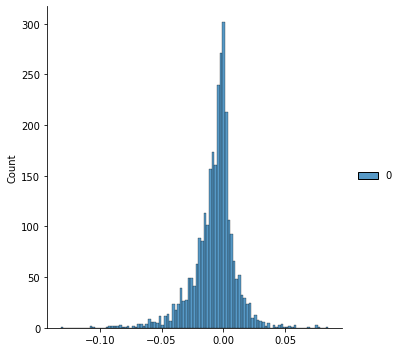

In [18]:
seed = [[0,0,0,1,1,0,0]]
weekends = np.concatenate(np.repeat(seed, 1000, axis=0))[:num_days]

plot_across_actual(train_mat, weekends, 1)

In [27]:
samples = np.load('arr_0.npy')

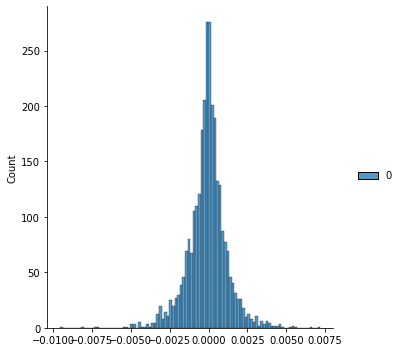

In [31]:
plot_across_samples(samples, weekends, 1)


## Effect of weekday

In [ ]:
def add_weekday_predictors(predictors): 
    """
    Adds one categorical idicating day of the week.
    Params: 
        Predictors (ndarray): predictors[i][j][k] indicates predictor k on day j 
            at node i 
    Returns: 
        ndarrya of dimension with 6 additional variables in the last dimension corresponding
        to the weekday 
    """
    cur_pred = predictors.shape[-1]
    shape = np.array(predictors.shape) + np.array([0,0,7])
    new_predictors = np.zeros(shape)
    new_predictors[:,:,:cur_pred] = predictors
    for i in range(7): 
        new_predictors[:,i%7,cur_pred + (i%7)] = np.ones(shape[0])
    return new_predictors[:,:,:-1]

def normalize(predictors):
    """
    Normalizes every variable using max 
    """
    normalization_constant =  np.max(np.max(predictors, axis=1), axis =0)
    return predictors/normalization_constant


In [ ]:
weather_data = pd.read_csv('../data/weather.csv')
new_predictors = add_weather_predictors(predictors, weather_data)
new_predictors = add_weekday_predictors(new_predictors)
new_predictors = normalize(new_predictors) 


In [ ]:
aadt_model_guide = autoguide.AutoDiagonalNormal(aadt_model)
num_iters = 1000
optimizer = torch.optim.Adam
optim_args = {'lr': 0.05}
optim_params = {
    'optimizer': optimizer,
    'optim_args':optim_args, 
    'step_size': 200,
    'gamma':0.1,
    'verbose':True}
scheduler = optim.StepLR(optim_params)

svi = SVI(aadt_model, aadt_model_guide, scheduler,loss=Trace_ELBO())

pyro.clear_param_store()
losses = []
train_mat_tens = torch.tensor(train_mat)
predictors_tens = torch.tensor(new_predictors).float()
num_predictors = predictors_tens.shape[-1]
print(predictors_tens.shape)

prev = np.inf
for i in range(num_iters): 
    elbo = svi.step(num_sites, num_days, num_predictors, predictors_tens, train_mat_tens)
    losses.append(elbo)
    if np.abs(elbo - prev) < 1:
        break
    prev = elbo
    if i % 50 == 0: 
        print("In step {} the Elbo is {}".format(i,elbo))


In [ ]:
elbo_df = pd.DataFrame({'Iteration': list(range(len(losses))), 'log-loss': np.log(losses[:])})
fig = px.line(elbo_df, x='Iteration', y='log-loss', title='Elbo')
fig.show()

In [ ]:
predict = Predict(negative_binomial_model,negative_binomial_guide, 400)
samples = predict(num_sites, num_days, num_predictors, predictors_tens)

In [ ]:
accidents = samples['accidents'].detach().numpy()

In [ ]:
train_mat.shape

In [ ]:
sns.displot(np.sum(accidents[:,4],axis = 1))

In [ ]:
subset = torch.distributions.Categorical(torch.ones(4,num_sites)/num_sites).sample().numpy()
print(subset)
ppc.plot_total_distributions(accidents,train_mat,(2,2),subset)

In [ ]:
ppc.plot(samples['accidents'].detach().numpy(), train_mat)

In [ ]:
ppc.plot_time_trend(accidents, train_mat)

In [ ]:
sns.displot(samples['betas'][:,10].detach().numpy())

## Changing to week days

In [ ]:
def add_weekdayweekend_predictors(predictors, first_week = np.array([0,0,0,1,1,0,0])): 
    """
    Adds one categorical idicating day of the week.
    Params: 
        Predictors (ndarray): predictors[i][j][k] indicates predictor k on day j 
            at node i 
    Returns: 
        ndarrya of dimension with 6 additional variables in the last dimension corresponding
        to the weekday 
    """
    num_days = predictors.shape[1]
    is_week = np.array([first_week[i%7] for i in range(num_days)])
    cur_pred = predictors.shape[-1]
    shape = np.array(predictors.shape) + np.array([0,0,1])
    new_predictors = np.zeros(shape)
    new_predictors[:,:,:cur_pred] = predictors
    new_predictors[:,:,-1] = is_week 
    return new_predictors

In [ ]:
weather_data = pd.read_csv('../data/weather.csv')
new_predictors = add_weather_predictors(predictors, weather_data)
new_predictors = add_weekdayweekend_predictors(new_predictors)
new_predictors = normalize(new_predictors)


In [ ]:
aadt_model_guide = autoguide.AutoDiagonalNormal(aadt_model)
num_iters = 1500
optimizer = torch.optim.Adam
optim_args = {'lr': 0.08}
optim_params = {
    'optimizer': optimizer,
    'optim_args':optim_args, 
    'step_size': 10,
    'gamma':0.1,
    'verbose':True}
scheduler = optim.StepLR(optim_params)

svi = SVI(aadt_model, aadt_model_guide, scheduler,loss=Trace_ELBO())

pyro.clear_param_store()
losses = []
train_mat_tens = torch.tensor(train_mat)
predictors_tens = torch.tensor(new_predictors).float()
num_predictors = predictors_tens.shape[-1]
print(predictors_tens.shape)

prev = np.inf
for i in range(num_iters): 
    elbo = svi.step(num_sites, num_days, num_predictors, predictors_tens, train_mat_tens)
    losses.append(elbo)
    if np.abs(elbo - prev) < 1:
        break
    prev = elbo
    if i % 50 == 0: 
        print("In step {} the Elbo is {}".format(i,elbo))

In [ ]:
predict = Predict(aadt_model, aadt_model_guide, 400)
samples = predict(num_sites, num_days, num_predictors, predictors_tens)

In [ ]:
from importlib import reload 
ppc = reload(helper_functions.ppc)

In [ ]:

accidents = samples['accidents'].detach().numpy()
np.sum(accidents[:,1], -1)
subset = torch.distributions.Categorical(torch.ones(4,num_sites)/num_sites).sample().numpy()
print(subset)
ppc.plot_total_distributions(accidents,train_mat,(2,2),subset)

In [ ]:
sns.displot(samples['betas'][:,-1].detach().numpy())

In [ ]:
ppc.plot_time_trend(accidents, train_mat, window=101)

## Assignment model to determine importance of predictors

In [ ]:
def beta_model(num_sites, num_days, num_predictors,predictors, data=None):
    params = {}
    with plate('betas_plates', num_predictors): 
        betas = pyro.sample('betas', dist.Normal(torch.zeros(num_predictors), 10 * torch.ones(num_predictors)))
        params['betas'] = betas
        with  plate('multiplier_plate', num_sites): 
            multipliers = pyro.sample('multipliers', dist.Beta(torch.ones(num_sites, num_predictors), torch.ones(num_sites, num_predictors)))
            params['multipliers'] = multipliers
            betas = multipliers * betas
            params['final_beta'] = betas
                                                         
                                                    
        
#    with plate('sites', size=num_sites, dim=-2):
#        bernoulli = pyro.sample('bernoulli',dist.Bernoulli(0.5 * torch.ones(num_sites,num_predictors)))
#        betas = bernoulli * betas
#        betas = betas * torch.ones(num_days,num_sites,num_predictors)
#        betas = betas.permute(1,0,2)
#        epsilon = pyro.sample('epsilon', dist.Normal(torch.zeros(num_sites), 5))
#        epsilon = epsilon.unsqueeze(-1).expand(num_sites, num_days)
#        theta = torch.exp(torch.sum(predictors * betas, axis = -1) + epsilon)
#        with plate('days', size=num_days, dim=-1):
#            accidents = pyro.sample('accidents', dist.NegativeBinomial(r,p), obs=data) 
            
    return params


In [ ]:
from scipy.stats import poisson
from scipy.stats import nbinom

In [ ]:
nbinom()